# 5. ラベルなしでの事前学習

## 5.1 生成テキストモデルを評価する

### GPTを使ってテキストを生成する

In [2]:
from GPTModel import GPTModel


In [3]:
import torch
from GPTModel import GPTModel

GPT_CONFIG_124M = {
  "vocab_size": 50257,
  "context_length": 256,
  "emb_dim": 768,
  "n_heads": 12,
  "n_layers": 12,
  "drop_rate": 0.1,
  "qkv_bias": False,  
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [4]:
# List 5-1

import tiktoken
from util import generate_text_simple

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dim
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0) # remove batch dim.
  return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
  model=model,
  idx=text_to_token_ids(start_context, tokenizer),
  max_new_tokens=10,
  context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### テキスト生成の損失を計算する

In [5]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,     1107, 588]])  #  "I really like"]
targets = torch.tensor ([[3626, 6100, 345],   # [" effort moves you",
                         [1107, 588, 11311]]) #  " really like chocolate"]

In [6]:
with torch.no_grad():
  logits = model(inputs)

probas = torch.softmax(logits, dim= -1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [7]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [8]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [9]:
text_idx = 0
target_brabs_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_brabs_1)

text_idx = 1
target_brabs_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_brabs_2)



Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [10]:
log_probas = torch.log(torch.cat((target_brabs_1, target_brabs_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [11]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [12]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [13]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [14]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [15]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


### 訓練データセットと検証データセットで損失を計算する

In [16]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
  text_data = file.read()

In [17]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [18]:
train_ratio = 0.90
split_idx   = int(train_ratio * len(text_data))
train_data  = text_data[:split_idx]
val_data    = text_data[split_idx:]

In [19]:
from dataloader import create_dataloader_v1

torch.manual_seed(123)

train_loader = create_dataloader_v1(
  train_data,
  batch_size=2,
  max_length=GPT_CONFIG_124M["context_length"],
  stride=GPT_CONFIG_124M["context_length"],
  drop_last=True,
  shuffle=True,
  num_workers=0
)

val_loader = create_dataloader_v1(
  val_data,
  batch_size=2,
  max_length=GPT_CONFIG_124M["context_length"],
  stride=GPT_CONFIG_124M["context_length"],
  drop_last=False,
  shuffle=False,
  num_workers=0,
)

In [20]:
print("Train loader:")
for x, y in train_loader:
  print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
  print(x.shape, y.shape)
  # print(x)
  # print(y)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [21]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(
    logits.flatten(0, 1), target_batch.flatten()
  )
  return loss

In [22]:
# List 5-2

def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss/num_batches


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

with torch.no_grad():
  train_loss  = calc_loss_loader(train_loader, model, device)
  val_loss    = calc_loss_loader(val_loader, model, device)

print("Training loss    :", train_loss)
print("Validataion loss :", val_loss)

Training loss    : 10.987583584255642
Validataion loss : 10.98110580444336


## 5.2 LLMを訓練する

In [24]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss  = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss    = calc_loss_loader(val_loader,   model, device, num_batches=eval_iter)

  model.train()
  return train_loss, val_loss


In [25]:
def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)

  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " "))
  model.train()

In [26]:
# List 5-3

def train_model_simple( model, train_loader, val_loader, optimizer, device,
                        num_epochs, eval_freq, eval_iter, start_context, tokenizer):
  train_losses, val_losses, track_tokens_seen = [], [], []
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()
      tokens_seen += input_batch.numel()
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model( model, train_loader, val_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
    generate_and_print_sample(model, tokenizer, device, start_context)
  return train_losses, val_losses, track_tokens_seen

In [27]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
  model, train_loader, val_loader, optimizer, device,
  num_epochs=num_epochs, eval_freq=5, eval_iter=5,
  start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epoches_seen, tokens_seen, trains_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(epoches_seen, train_losses, label="Training loss")
  ax1.plot(epoches_seen, val_losses, linestyle="-.", label="Validataion loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, trains_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()
  

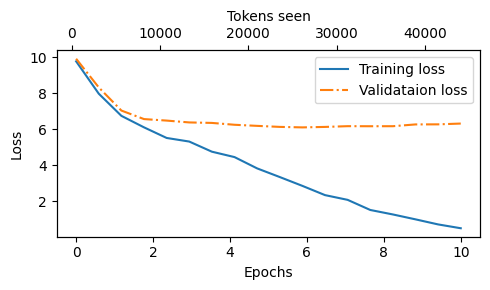

In [29]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 5.3 ランダム性をコントロールするデコーディング戦略

In [30]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [32]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple( model=model, idx=text_to_token_ids("Every effort moves you", tokenizer), 
                                  max_new_tokens=25, context_size=GPT_CONFIG_124M["context_length"])
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### 温度スケーリング

In [33]:
vocab = {
  "closer": 0,
  "every": 1,
  "effort": 2,
  "forward": 3,
  "inches": 4,
  "moves": 5,
  "pizza": 6,
  "toward": 7,
  "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [34]:
next_token_logits = torch.tensor(
  [4.51, 0.89, -1.9, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [35]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [46]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [47]:
def print_sampled_tokens(probas):
  torch.manual_seed(123)
  sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
  sampled_ids = torch.bincount(torch.tensor(sample))
  for i, freq in enumerate(sampled_ids):
    print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [48]:
def softmax_with_temperature(logits, temperature):
  scaled_logits = logits / temperature
  return torch.softmax(scaled_logits, dim=0)

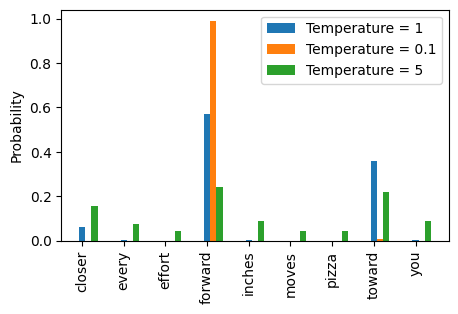

In [51]:
temperatures = [1, 0.1, 5]
scaled_probs = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
  rects = ax.bar(x + i * bar_width, scaled_probs[i], bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout
plt.show()

### top-k サンプリング

In [52]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [53]:
new_logits = torch.where(
  condition=next_token_logits < top_logits[-1],
  input=torch.tensor(float('-inf')),
  other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [54]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### テキスト生成関数を修正する

In [ ]:
# List 5-4

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]

    if top_k is not None:
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[: -1]
      logits = torch.where(
        logits < min_val,
        torch.tensor(float('-inf')).to(logits.device),
        logits
      )
    
    if temperature > 0.0:
      logits = logits / temperature
      probas = torch.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probas, num_samples=1)
    else:
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)

    if idx_next == eos_id:
      break

    idx = torch.cat((idx, idx_next), dim=1)

  return idx

In [58]:
torch.manual_seed(123)

token_ids = generate(
  model=model,
  idx=text_to_token_ids("Every effort moves you", tokenizer),
  max_new_tokens=15,
  context_size=GPT_CONFIG_124M["context_length"],
  top_k=25,
  temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

TypeError: generate() got an unexpected keyword argument 'model'